In [1]:
#@title Import & seed
import time
import re
import os
import math
import numpy as np
from matplotlib import pyplot as plt
import requests
import collections
import pickle
import copy, random
import nltk as nl
nl.download('punkt')
from itertools import zip_longest

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Reshape, BatchNormalization, Dense, Dropout, concatenate,
    Embedding, LSTM, Dense, GRU, Bidirectional, Add
)
from tensorflow.keras.activations import elu, relu, softmax, sigmoid
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical

print(tf.__version__)

np.random.seed(1234)
!nvidia-smi

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
2.3.0
Sun Aug 16 18:42:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+

In [2]:
#@title Setup wandb
!pip install wandb
!wandb login f57cb185d23a8b60d349a4ea02278a6eee82550a
import wandb
wandb.init(project="deep_comedy", name="daniele-9")

     |████████████████████████████████| 1.4MB 5.4MB/s 
     |████████████████████████████████| 102kB 13.2MB/s 
     |████████████████████████████████| 122kB 31.1MB/s 
     |████████████████████████████████| 102kB 12.3MB/s 
     |████████████████████████████████| 163kB 30.7MB/s 
     |████████████████████████████████| 71kB 10.9MB/s 
     |████████████████████████████████| 71kB 11.1MB/s 
  Created wheel for watchdog: filename=watchdog-0.10.3-cp36-none-any.whl size=73870 sha256=a5aa168cb3e15e24a2e0a38a07ebf8a46976d3c9ed59580a92964cefe325da65
  Stored in directory: /root/.cache/pip/wheels/a8/1d/38/2c19bb311f67cc7b4d07a2ec5ea36ab1a0a0ea50db994a5bc7
  Created wheel for gql: filename=gql-0.2.0-cp36-none-any.whl size=7630 sha256=e214e32ba282aa94baad4c5d55140f70b8a3e53e9ac4fec9aed8f829dabae971
  Stored in directory: /root/.cache/pip/wheels/ce/0e/7b/58a8a5268655b3ad74feef5aa97946f0addafb3cbb6bd2da23
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=

W&B Run: https://app.wandb.ai/veri/deep_comedy/runs/3b2kk41d

In [3]:
#@title Model

vocab_size = 1797
wandb.config.num_layers = 6
wandb.config.d_model = 128
wandb.config.dff = 512
wandb.config.num_heads = 4
input_vocab_size = vocab_size
target_vocab_size = vocab_size
wandb.config.dropout = 0.1
batch_len = 304
EPOCHS = 200

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

def create_padding_mask(seq):   
    seq = tf.cast(tf.math.equal(seq, pad), tf.float32)
    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.
    
    Args:
        q: query shape == (..., seq_len_q, depth)
        k: key shape == (..., seq_len_k, depth)
        v: value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable 
            to (..., seq_len_q, seq_len_k). Defaults to None.
        
    Returns:
        output, attention_weights
    """
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  
    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)
    return output, attention_weights

def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])


class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)
            
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
        
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)
        
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
        
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention, 
                                    (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        return output, attention_weights

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        
    def __call__(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
        
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
        
        return out2

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)
    
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
        
        
    def __call__(self, x, enc_output, training, 
            look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        
        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
        
        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
        
        return out3, attn_weights_block1, attn_weights_block2

class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)   ########## rm ??????
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                        for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
            
    def __call__(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        return x  # (batch_size, input_seq_len, d_model)

class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
                maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                        for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def __call__(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                look_ahead_mask, padding_mask)
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
        
        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
                target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                            input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                            target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
        
    def __call__(self, inp, tar, training, enc_padding_mask, 
            look_ahead_mask, dec_padding_mask):

        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
        
        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
        
        return final_output, attention_weights

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(wandb.config.d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='train_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

transformer = Transformer(wandb.config.num_layers, wandb.config.d_model, 
                          wandb.config.num_heads, wandb.config.dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=wandb.config.dropout)
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)
    
    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)
    
    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    
    return enc_padding_mask, combined_mask, dec_padding_mask

checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, batch_len), dtype=tf.int64),
    tf.TensorSpec(shape=(None, batch_len), dtype=tf.int64),
]

@tf.function()#(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                    True, 
                                    enc_padding_mask, 
                                    combined_mask, 
                                    dec_padding_mask)
        loss = loss_function(tar_real, predictions)
        gradients = tape.gradient(loss, transformer.trainable_variables)    
        optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    
    train_loss(loss)
    train_accuracy(tar_real, predictions)

@tf.function()#(input_signature=train_step_signature)
def val_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    
    predictions, _ = transformer(inp, tar_inp, 
                                False, 
                                enc_padding_mask, 
                                combined_mask, 
                                dec_padding_mask)
    loss = loss_function(tar_real, predictions)
    
    val_loss(loss)
    val_accuracy(tar_real, predictions)


In [4]:
#@title Preprocessing

def get_hyp_lm_tercets(tercets):
    new_tercets = []
    for tercet in tercets:
        new_tercets.append([])
        for verse in tercet:
            new_tercets[-1].append([])
            for hyp_w in verse:
                new_tercets[-1][-1].extend(hyp_w)
                new_tercets[-1][-1].append('<SEP>')
            new_tercets[-1][-1] = new_tercets[-1][-1][:-1]

    return new_tercets

def is_vowel(c):
    return c in 'aeiouAEIOUàìíèéùúüòï'

def unsplittable_cons():
    u_cons = []
    for c1 in ('b', 'c', 'd', 'f', 'g', 'p', 't', 'v'):
        for c2 in ('l', 'r'):
            u_cons.append(c1 + c2)

    others = ['gn', 'gh', 'ch']
    u_cons.extend(others)
    return u_cons


def are_cons_to_split(c1, c2):
    to_split = ('cq', 'cn', 'lm', 'rc', 'bd', 'mb', 'mn', 'ld', 'ng', 'nd', 'tm', 'nv', 'nc', 'ft', 'nf', 'gm', 'fm', 'rv', 'fp')
    return (c1 + c2) in to_split or (not is_vowel(c1) and (c1 == c2)) or ((c1 + c2) not in unsplittable_cons()) and (
        (not is_vowel(c1)) and (not is_vowel(c2)) and c1 != 's')


def is_diphthong(c1, c2):
    return (c1 + c2) in ('ia', 'ie', 'io', 'iu', 'ua', 'ue', 'uo', 'ui', 'ai', 'ei', 'oi', 'ui', 'au', 'eu', 'ïe', 'iú', 'iù')


def is_triphthong(c1, c2, c3):
    return (c1 + c2 + c3) in ('iai', 'iei', 'uoi', 'uai', 'uei', 'iuo')


def is_toned_vowel(c):
    return c in 'àìèéùòï'

def has_vowels(sy):
    for c in sy:
        if is_vowel(c):
            return True
    return False


def hyphenation(word):
    """
    Split word in syllables
    :param word: input string
    :return: a list containing syllables of the word
    """
    if not word or word == '':
        return []
    # elif len(word) == 3 and (is_vowel(word[1]) and is_vowel(word[2]) and not is_toned_vowel(word[2]) and (
    #     not is_diphthong(word[1], word[2]) or (word[1] == 'i'))):
    elif len(word) == 3 and (is_vowel(word[1]) and is_vowel(word[2]) and not is_toned_vowel(word[2]) and (
        not is_diphthong(word[1], word[2]))):
        return [word[:2]] + [word[2]]
    elif len(word) == 3 and is_vowel(word[0]) and not is_vowel(word[1]) and is_vowel(word[2]):
        return [word[:2]] + [word[2]]
    elif len(word) == 3:
        return [word]

    syllables = []
    is_done = False
    count = 0
    while not is_done and count <= len(word) - 1:
        syllables.append('')
        c = word[count]
        while not is_vowel(c) and count < len(word) - 1:
            syllables[-1] = syllables[-1] + c
            count += 1
            c = word[count]

        syllables[-1] = syllables[-1] + word[count]

        if count == len(word) - 1:
            is_done = True
        else:
            count += 1

            if count < len(word) and not is_vowel(word[count]):
                if count == len(word) - 1:
                    syllables[-1] += word[count]
                    count += 1
                elif count + 1 < len(word) and are_cons_to_split(word[count], word[count + 1]):
                    syllables[-1] += word[count]
                    count += 1
                elif count + 2 < len(word) and not is_vowel(word[count + 1]) and not is_vowel(word[count + 2]) and word[
                    count] != 's':
                    syllables[-1] += word[count]
                    count += 1
            elif count < len(word):
                if count + 1 < len(word) and is_triphthong(word[count - 1], word[count], word[count + 1]):
                    syllables[-1] += word[count] + word[count + 1]
                    count += 2
                elif is_diphthong(word[count - 1], word[count]):
                    syllables[-1] += word[count]
                    count += 1

                if count + 1 < len(word) and are_cons_to_split(word[count], word[count + 1]):
                    syllables[-1] += word[count]
                    count += 1

            else:
                is_done = True

    if not has_vowels(syllables[-1]) and len(syllables) > 1:
        syllables[-2] = syllables[-2] + syllables[-1]
        syllables = syllables[:-1]

    return syllables



def get_dc_hyphenation(canti):
    hyp_canti, hyp_tokens = [], []
    for canto in canti:
        hyp_canti.append([])
        for verso in canto:
            syllables = seq_hyphentation(verso)
            hyp_canti[-1].append(syllables)
            for syllable in syllables:
                hyp_tokens.extend(syllable)

    return hyp_canti, hyp_tokens


def seq_hyphentation(words):
    """
    Converts words in a list of strings into lists of syllables
    :param words: a list of words (strings)
    :return: a list of lists containing word syllables
    """
    return [hyphenation(w) for w in words]


def get_dc_cantos(filename, encoding=None):
    # raw_data = read_words(filename=filename)
    cantos, words, raw = [], [], []
    with open(filename, "r", encoding=encoding) as f:
        for line in f:
            sentence = line.strip()
            sentence = str.replace(sentence, "\.", " \. ")
            sentence = str.replace(sentence, "[", '')
            sentence = str.replace(sentence, "]", '')
            sentence = str.replace(sentence, "-", '')
            sentence = str.replace(sentence, ";", " ; ")
            sentence = str.replace(sentence, ",", " , ")
            # sentence = str.replace(sentence, " \'", '')
            sentence = str.replace(sentence, "\'", ' \' ')
            if len(sentence) > 1:
                # sentence = sentence.translate(string.punctuation)
                tokenized_sentence = nl.word_tokenize(sentence)
                # tokenized_sentence = sentence.split()
                tokenized_sentence = [w.lower() for w in tokenized_sentence if len(w) > 0]
                tokenized_sentence = [w for w in tokenized_sentence if "," not in w]
                tokenized_sentence = [w for w in tokenized_sentence if "." not in w]
                tokenized_sentence = [w for w in tokenized_sentence if ":" not in w]
                tokenized_sentence = [w for w in tokenized_sentence if ";" not in w]
                tokenized_sentence = [w for w in tokenized_sentence if "«" not in w]
                tokenized_sentence = [w for w in tokenized_sentence if "»" not in w]
                # ts = []
                ts = tokenized_sentence
                # [ts.extend(re.split("(\')", e)) for e in tokenized_sentence]
                tokenized_sentence = [w for w in ts if len(w) > 0]

                if len(tokenized_sentence) == 2:
                    cantos.append([])
                    raw.append([])
                elif len(tokenized_sentence) > 2:
                    raw[-1].append(sentence)
                    cantos[-1].append(tokenized_sentence)
                    words.extend(tokenized_sentence)

    return cantos, words, raw


def create_tercets(cantos):
    tercets = []
    for i,canto in enumerate(cantos):
        for v,verse in enumerate(canto):
            if v%3 == 0:
                tercets.append([])

            tercets[-1].append(verse)
        tercets = tercets[:-1]  # removes the last malformed tercets (only 2 verses)

    return tercets

def pad_list(l, pad_token, max_l_size, keep_lasts=False, pad_right=True):
    """
    Adds a padding token to a list
    inputs:
    :param l: input list to pad.
    :param pad_token: value to add as padding.
    :param max_l_size: length of the new padded list to return,
    it truncates lists longer that 'max_l_size' without adding
    padding values.
    :param keep_lasts: If True, preserves the max_l_size last elements
    of a sequence (by keeping the same order).  E.g.:
    if keep_lasts is True and max_l_size=3 [1,2,3,4] becomes [2,3,4].


    :return: the list padded or truncated.
    """
    to_pad = []
    max_l = min(max_l_size, len(l))  # maximum len
    l_init = len(l) - max_l if len(l) > max_l and keep_lasts else 0  # initial position where to sample from the list
    l_end = len(l) if len(l) > max_l and keep_lasts else max_l
    for i in range(l_init, l_end):
        to_pad.append(l[i])

    # for j in range(len(l), max_l_size):
    #     to_pad.append(pad_token)
    pad_tokens = [pad_token] * (max_l_size-len(l))
    padded_l = to_pad + pad_tokens if pad_right else pad_tokens + to_pad

    return padded_l


def save_data(data, file):
    with open(file, 'wb') as output:
        pickle.dump(data, output, pickle.HIGHEST_PROTOCOL)

def load_data(file):
    with open(file, 'rb') as obj:
        return pickle.load(obj)

def print_and_write(file, s):
    print(s)
    file.write(s)


class Vocabulary(object):
    def __init__(self, vocab_size=None):
        self.dictionary = dict()
        self.rev_dictionary = dict()
        self.count = []
        self.special_tokens = []
        self.vocab_size = vocab_size

    def build_vocabulary_from_counts(self, count, special_tokens=[]):
        """
        Sets all the attributes of the Vocabulary object.
        :param count: a list of lists as follows: [['token', number_of_occurrences],...]
        :param special_tokens: a list of strings. E.g. ['<EOS>', '<PAD>',...]
        :return: None
        """

        dictionary = dict()
        for word, _ in count:
            dictionary[word] = len(dictionary)

        # adding eventual special tokens to the dictionary (e.g. <EOS>,<PAD> etc..)
        d = len(dictionary)
        for i, token in enumerate(special_tokens):
            dictionary[token] = d + i

        self.count = count
        self.dictionary = dictionary
        self.rev_dictionary = dict(zip(self.dictionary.values(), self.dictionary.keys()))
        self.special_tokens = special_tokens
        self.vocab_size = len(dictionary)

    def build_vocabulary_from_tokens(self, tokens, vocabulary_size=None, special_tokens=[]):
        """
        Given a list of tokens, it sets the Vocabulary object attributes by constructing
        a dictionary mapping each token to a unique id.
        :param tokens: a list of strings.
         E.g. ["the", "cat", "is", ... ".", "the", "house" ,"is" ...].
         NB: Here you should put all your token instances of the corpus.
        :param vocabulary_size: The number of elements of your vocabulary. If there are more
        than 'vocabulary_size' elements on tokens, it considers only the 'vocabulary_size'
        most frequent ones.
        :param special_tokens: Optional. A list of strings. Useful to add special tokens in vocabulary.
        If you don't have any, keep it empty.
        :return: None
        """

        vocabulary_size = vocabulary_size if vocabulary_size is not None else self.vocab_size
        vocabulary_size = vocabulary_size - (len(special_tokens) + 1) if vocabulary_size else None
        # counts occurrences of each token
        count = [['<UNK>', -1]]
        count.extend(collections.Counter(tokens).most_common(vocabulary_size))  # takes only the most frequent ones, if size is None takes them all
        self.build_vocabulary_from_counts(count, special_tokens)  # actually build the vocabulary
        self._set_unk_count(tokens)  # set the number of OOV instances

    @staticmethod
    def merge_vocabulary(vocab0, vocab1, vocabulary_size=-1):
        """
        Merge two Vocabulary objects into a new one.
        :param vocab0: first Vocabulary object
        :param vocab1: second Vocabulary object
        :param vocabulary_size: parameter to decide the merged vocabulary size.
        With default value -1, all the words of both vocabularies are preserved.
        When set to 0, the size of the vocabulary is set to the size of vocab0,
        when set to 1 it is kept the size of vocab1.
        :return: a new vocabulary
        """
        # get size of the new vocabulary
        vocab_size = vocab0.vocab_size + vocab1.vocab_size if vocabulary_size == -1 else vocabulary_size
        merged_special_tokens = list(set(vocab0.special_tokens) | set(vocab1.special_tokens))

        # merge the counts from the two vocabularies and then selects the most_common tokens
        merged_counts = collections.Counter(dict(vocab0.count)) + collections.Counter(dict(vocab1.count))
        merged_counts = merged_counts.most_common(vocab_size)
        count = [['<UNK>', -1]]
        count.extend(merged_counts)

        # create the new vocabulary
        merged_vocab = Vocabulary(vocab_size)
        merged_vocab.build_vocabulary_from_counts(count, merged_special_tokens)
        return merged_vocab

    @staticmethod
    def merge_vocabularies(vocab_list, vocab_size=None):
        """
        Join a list of vocabularies into a new one.
        :param vocab_list: a list of Vocabulary objects
        :param vocab_size: the maximum size of the merged vocabulary.
        :return: a vocabulary merging them all.
        """
        vocab_size = vocab_size if vocab_size else sum([v.vocab_size for v in vocab_list])
        merged_vocab = Vocabulary(vocab_size)
        for voc in vocab_list:
            merged_vocab = Vocabulary.merge_vocabulary(merged_vocab, voc, vocab_size)
        return merged_vocab

    def string2id(self, dataset):
        """
        Converts a dataset of strings into a dataset of ids according to the object dictionary.
        :param dataset: any string-based dataset with any nested lists.
        :return: a new dataset, with the same shape of dataset, where each string is mapped into its
        corresponding id associated in the dictionary (0 for unknown tokens).
        """

        def _recursive_call(items):
            new_items = []
            for item in items:
                if isinstance(item, str) or isinstance(item, int) or isinstance(item, float):
                    new_items.append(self.word2id(item))
                else:
                    new_items.append(_recursive_call(item))
            return new_items

        return _recursive_call(dataset)

    def id2string(self, dataset):
        """
        Converts a dataset of integer ids into a dataset of string according to the reverse dictionary.
        :param dataset: any int-based dataset with any nested lists. Allowed types are int, np.int32, np.int64.
        :return: a new dataset, with the same shape of dataset, where each token is mapped into its
        corresponding string associated in the reverse dictionary.
        """
        def _recursive_call(items):
            new_items = []
            for item in items:
                if isinstance(item, int) or isinstance(item, np.int) or isinstance(item, np.int32) or isinstance(item, np.int64):
                    new_items.append(self.id2word(item))
                else:
                    new_items.append(_recursive_call(item))
            return new_items

        return _recursive_call(dataset)

    def word2id(self, item):
        """
        Maps a string token to its corresponding id.
        :param item: a string.
        :return: If the token belongs to the vocabulary, it returns an integer id > 0, otherwise
        it returns the value associated to the unknown symbol, that is typically 0.
        """
        return self.dictionary[item] if item in self.dictionary else self.dictionary['<UNK>']

    def id2word(self, token_id):
        """
        Maps an integer token to its corresponding string.
        :param token_id: an integer.
        :return: If the id belongs to the vocabulary, it returns the string
        associated to it, otherwise it returns the string associated
        to the unknown symbol, that is '<UNK>'.
        """

        return self.rev_dictionary[token_id] if token_id in self.rev_dictionary else self.rev_dictionary[self.dictionary['<UNK>']]

    def get_unk_count(self):
        return self.count[0][1]

    def _set_unk_count(self, tokens):
        """
        Sets the number of OOV instances in the tokens provided
        :param tokens: a list of tokens
        :return: None
        """
        data = list()
        unk_count = 0
        for word in tokens:
            if word in self.dictionary:
                index = self.dictionary[word]
            else:
                index = 0  # dictionary['<UNK>']
                unk_count += 1
            data.append(index)
        self.count[0][1] = unk_count

    def add_element(self, name, is_special_token=False):
        if name not in self.dictionary:
            self.vocab_size += 1
            self.dictionary[name] = self.vocab_size
            self.rev_dictionary[self.vocab_size] = name

            if is_special_token:
                self.special_tokens = list(self.special_tokens)
                self.special_tokens.append(name)

            self.count.append([name, 1])

    def set_vocabulary(self, dictionary, rev_dictionary, special_tokens, vocab_size):
        self.dictionary = dictionary,
        self.rev_dictionary = rev_dictionary
        self.special_tokens = special_tokens
        self.vocab_size = vocab_size

    @staticmethod
    def load_vocabulary(filename):
        return load_data(filename)

    def save_vocabulary(self, filename):
        save_data(self, filename)

class SyLMDataset(object):
    def __init__(self, config, sy_vocab=None):
        self.config = config
        self.vocabulary = sy_vocab

        self.raw_train_x = []
        self.raw_val_x = []
        self.raw_test_x = []
        self.raw_x = []

        self.train_x, self.train_y = [], []
        self.val_x, self.val_y = [], []
        self.test_x, self.test_y = [], []
        self.x, self.y = [], []

    def initialize(self, sess):
        pass

    def load(self, sources):
        """
        Extract raw texts form sources and gather them all together.
        :param sources: a string or an iterable of strings containing the file(s)
        to process in order to build the dataset.
        :return: a list of raw strings.
        """
        return NotImplementedError

    def build(self, sources, split_size=0.8):
        """
        :param sources: a string or an iterable of strings containing the file(s)
        to process in order to build the dataset.
        :param split_size: the size to split the dataset, set >=1.0 to not split.
        """

        raw_x = self.load(sources)
        # raw_x = self.tokenize([self.preprocess(ex) for ex in raw_x])  # fixme
        # splitting data
        self.raw_x = raw_x
        if split_size < 1.0:
            self.raw_train_x, self.raw_test_x = self.split(self.raw_x, train_size=split_size)
            self.raw_train_x, self.raw_val_x = self.split(self.raw_train_x, train_size=split_size)
        else:
            self.raw_train_x = self.raw_x

        if self.vocabulary is None:
            # creates vocabulary
            tokens = [item for sublist in self.raw_train_x for item in sublist]  # get tokens
            special_tokens = ("<GO>", "<PAD>", "<SEP>", "<EOS>", "<EOV>")
            self._create_vocab(tokens, special_tokens=special_tokens)

        # creates x,y for train
        self.train_x = self._build_dataset(self.raw_train_x, insert_go=True, max_len=self.config.sentence_max_len, shuffle=False)
        self.train_y = self._build_dataset(self.raw_train_x, insert_go=True, max_len=self.config.sentence_max_len, shuffle=False)

        # creates x,y for validation
        self.val_x = self._build_dataset(self.raw_val_x, insert_go=True, max_len=self.config.sentence_max_len, shuffle=False)
        self.val_y = self._build_dataset(self.raw_val_x, insert_go=True, max_len=self.config.sentence_max_len, shuffle=False)

        # creates x,y for validation
        self.test_x = self._build_dataset(self.raw_test_x, insert_go=True, max_len=self.config.sentence_max_len, shuffle=False)
        self.test_y = self._build_dataset(self.raw_test_x, insert_go=True, max_len=self.config.sentence_max_len, shuffle=False)

    def _create_vocab(self, tokens, special_tokens=("<PAD>", "<GO>", "<SEP>", "<EOV>", "<EOS>")):
        """
        Create the vocabulary. Special tokens can be added to the tokens obtained from
        the corpus.
        :param tokens: a list of all the tokens in the corpus. Each token is a string.
        :param special_tokens: a list of strings.
        """
        vocab = Vocabulary(vocab_size=self.config.input_vocab_size)
        vocab.build_vocabulary_from_tokens(tokens, special_tokens=special_tokens)
        self.vocabulary = vocab

    @staticmethod
    def split(raw_data, train_size=0.8):
        size = math.floor(len(raw_data)*train_size)
        return raw_data[:size], raw_data[size:]

    @staticmethod
    def preprocess(txt):
        return txt

    @staticmethod
    def shuffle(x):
        return random.sample(x, len(x))

    @staticmethod
    def tokenize(txt):
        return txt

    def _build_dataset(self, raw_data, max_len=100, insert_go=True, keep_lasts=False, pad_right=True, shuffle=True):
        """
        Converts all the tokens in e1_raw_data by mapping each token with its corresponding
        value in the dictionary. In case of token not in the dictionary, they are assigned to
        a specific id. Each sequence is padded up to the seq_max_len setup in the config.

        :param raw_data: list of sequences, each sequence is a list of tokens (strings).
        :param max_len: max length of a sequence, crop longer and pad smaller ones.
        :param insert_go: True to insert <GO>, False otherwise.
        :param keep_lasts: True to truncate initial elements of a sequence.
        :param pad_right: pad to the right (default value True), otherwise pads to left.
        :param shuffle: Optional. If True data are shuffled.
        :return: A list of sequences where each token in each sequence is an int id.
        """
        dataset = []
        for sentence in raw_data:
            sentence_ids = [self.vocabulary.word2id("<GO>")] if insert_go else []
            sentence_ids.extend([self.vocabulary.word2id(w) for w in sentence])
            sentence_ids.append(self.vocabulary.word2id("<EOS>"))
            sentence_ids = pad_list(sentence_ids, self.vocabulary.word2id("<PAD>"), max_len, keep_lasts=keep_lasts, pad_right=pad_right)

            dataset.append(sentence_ids)

        if shuffle:
            return random.sample(dataset, len(dataset))
        else:
            return dataset

    def get_batches(self, batch_size=32, split_sel='train'):
        """
        Iterator over the training set. Useful method to run experiments.
        :param batch_size: size of the mini_batch
        :return: input and target.
        """
        if split_sel == 'train':
            x, y = self.train_x, self.train_y
        elif split_sel == 'val':
            x, y = self.val_x, self.val_y
        else:
            x, y = self.test_x, self.test_y
        
        i = 0#random.randint(0, batch_size)
        batches = []
        eov = self.vocabulary.word2id("<EOV>")
        go = self.vocabulary.word2id("<GO>")
        # prepare batches
        while i < len(x):
            j = 0
            batch_x, batch_y = [], []
            while j < batch_size and i+j<len(x):
                for c in x[i+j]:
                  batch_x.append(c)
                batch_x.append(eov)
                for c in y[i+j]:
                  batch_y.append(c)
                batch_y.append(eov)
                j += 1
            i += batch_size
            batches.append((batch_x, batch_y))

        # supply
        i = 0
        while i < len(batches):
            yield batches[i][0], batches[i][1]
            i += 1

class DanteSyLMDataset(SyLMDataset):
    def __init__(self, config, sy_vocab=None):
        """
        Class to create a dataset from Dante Alighieri's Divine Comedy.
        :param config: a Config object
        :param sy_vocab: (optional) a Vocabulary object where tokens of the dictionary
        are syllables. If None, the vocabulary is create automatically from the source.
        """
        super().__init__(config, sy_vocab)

    def load(self, sources):
        """
        Load examples from dataset
        :param sources: data filepath.
        :return:
        """
        canti, _, raw = get_dc_cantos(filename=sources)  # get raw data from file
        canti, tokens = get_dc_hyphenation(canti)  # converts each

        tercets = create_tercets(canti)
        tercets = get_hyp_lm_tercets(tercets)

        x = []
        for tercet in tercets:
            x.append([])
            for verse in tercet:
                x[-1].extend(verse)
                x[-1].append("<EOV>")

        #x = self.shuffle(x)
        return x

def seq2str(seq):
    def output2string(batch, rev_vocabulary, special_tokens, end_of_tokens):
        to_print = ''
        for token in batch:
            if token in special_tokens:
                to_print += ' '
            elif end_of_tokens and token in end_of_tokens:
                to_print += '\n'
            elif token in rev_vocabulary:
                to_print += rev_vocabulary[token]
            else:
                to_print += '<UNK>'
        return to_print

    return output2string(seq, poetry_sy_lm_dataset.vocabulary.rev_dictionary,
      special_tokens=[poetry_sy_lm_dataset.vocabulary.word2id("<PAD>"), 0, poetry_sy_lm_dataset.vocabulary.word2id("<SEP>"),
                      poetry_sy_lm_dataset.vocabulary.word2id("<GO>"), poetry_sy_lm_dataset.vocabulary.word2id("<EOS>")],
      end_of_tokens=[poetry_sy_lm_dataset.vocabulary.word2id("<EOV>")])

class cnfg:
  vocab_size = 1884
  input_vocab_size = 1884
  emb_size = 300
  sentence_max_len = 75

config = cnfg()
poetry_sy_lm_dataset = DanteSyLMDataset(config, sy_vocab=None)
url = "https://gitlab.com/zugo91/nlgpoetry/-/raw/release/data/la_divina_commedia.txt"
response = requests.get(url)
response.encoding = 'ISO-8859-1'
fi = open("divcom.txt","w")
fi.write(response.text)
fi.close()
data_path = os.path.join(os.getcwd(), "divcom.txt")  # dataset location, here just the name of the source file
poetry_sy_lm_dataset.build(data_path, split_size=0.9)  # actual creation of  vocabulary (if not provided) and dataset
print("Train size: " + str(len(poetry_sy_lm_dataset.train_y)))
print("Val size: " + str(len(poetry_sy_lm_dataset.val_y)))
print("Test size: " + str(len(poetry_sy_lm_dataset.test_y)))

eov = poetry_sy_lm_dataset.vocabulary.word2id("<EOV>")
pad = poetry_sy_lm_dataset.vocabulary.word2id("<PAD>")
go = poetry_sy_lm_dataset.vocabulary.word2id("<GO>")
eos = poetry_sy_lm_dataset.vocabulary.word2id("<EOS>")

batches = [b for b in poetry_sy_lm_dataset.get_batches(4)]
print(batches[0][0])
print(batches[0][1])
print(len(batches[0][0]))
val_b = [b for b in poetry_sy_lm_dataset.get_batches(4, split_sel='val')]
print(val_b[0][0])
print(val_b[0][1])
print(len(val_b[0][0]))
test_b = [b for b in poetry_sy_lm_dataset.get_batches(4, split_sel='test')]
print(test_b[0][0])
print(test_b[0][1])
print(len(test_b[0][0]))

Train size: 3815
Val size: 424
Test size: 472
[1792, 84, 1794, 339, 198, 1794, 50, 1794, 284, 188, 1794, 6, 1794, 24, 136, 1794, 37, 14, 1796, 27, 1794, 32, 61, 509, 1794, 18, 1794, 52, 5, 1794, 404, 47, 1794, 40, 276, 30, 1796, 89, 1794, 8, 1794, 6, 683, 14, 1794, 264, 1794, 92, 5, 1794, 655, 32, 14, 1796, 1795, 1793, 1793, 1793, 1793, 1793, 1793, 1793, 1793, 1793, 1793, 1793, 1793, 1793, 1793, 1793, 1793, 1793, 1793, 1793, 1793, 1796, 1792, 585, 1794, 78, 9, 1794, 5, 1794, 238, 1794, 162, 1794, 92, 5, 1794, 57, 1794, 12, 45, 1794, 116, 30, 1796, 4, 63, 1794, 404, 47, 1794, 404, 748, 148, 1794, 4, 1794, 5, 1203, 1794, 4, 1794, 120, 10, 1796, 7, 1794, 84, 1794, 166, 536, 1794, 32, 24, 47, 1794, 8, 1794, 455, 30, 1794, 153, 1796, 1795, 1793, 1793, 1793, 1793, 1793, 1793, 1793, 1793, 1793, 1793, 1793, 1793, 1793, 1796, 1792, 792, 1794, 3, 1794, 57, 1794, 5, 22, 30, 1794, 7, 1794, 49, 12, 1794, 57, 1794, 64, 1794, 144, 10, 1796, 22, 1794, 18, 1794, 416, 202, 1794, 50, 1794, 154, 1794, 46,

In [5]:
 #@title Train loop

for epoch in range(EPOCHS):
    random.shuffle(batches)
    start = time.time()
    
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    for (batch, (inp, tar)) in enumerate(batches):
        if (len(inp) != batch_len or len(tar) != batch_len):
            print("discarded batch", batch)
            continue
        train_step(np.expand_dims(inp, axis=0), np.expand_dims(tar, axis=0))
        
        if batch % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
                epoch + 1, batch, train_loss.result(), train_accuracy.result()))
        
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))

    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, train_loss.result(), train_accuracy.result()))
    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

    wandb.log({
        'train_loss': train_loss.result(),
        'train_accuracy': train_accuracy.result()
    }, step=epoch+1)

    # validation
    if epoch % 5 == 0:
        loss_l, acc_l = [], []
        for (batch, (inp, tar)) in enumerate(val_b):
            val_loss.reset_states()
            val_accuracy.reset_states()
            
            if (len(inp) != batch_len or len(tar) != batch_len):
                print("discarded batch", batch)
                continue

            val_step(np.expand_dims(inp, axis=0), np.expand_dims(tar, axis=0))

            loss_l.append(val_loss.result())
            acc_l.append(val_accuracy.result())

        loss_mean = sum(loss_l)/len(loss_l)
        acc_mean = sum(acc_l)/len(acc_l)
        print('Epoch {} VALIDATION: Loss {:.4f} Accuracy {:.4f}\n'.format(epoch + 1, loss_mean, acc_mean))

        wandb.log({
            'val_loss': loss_mean,
            'val_accuracy': acc_mean
        }, step=epoch+1)


Epoch 1 Batch 0 Loss 7.5457 Accuracy 0.0000
Epoch 1 Batch 50 Loss 7.1950 Accuracy 0.0913
Epoch 1 Batch 100 Loss 6.8159 Accuracy 0.1755
Epoch 1 Batch 150 Loss 6.5528 Accuracy 0.2065
Epoch 1 Batch 200 Loss 6.3223 Accuracy 0.2200
discarded batch 247
Epoch 1 Batch 250 Loss 6.0908 Accuracy 0.2290
Epoch 1 Batch 300 Loss 5.8259 Accuracy 0.2583
Epoch 1 Batch 350 Loss 5.5806 Accuracy 0.2815
Epoch 1 Batch 400 Loss 5.3624 Accuracy 0.2989
Epoch 1 Batch 450 Loss 5.1642 Accuracy 0.3135
Epoch 1 Batch 500 Loss 4.9934 Accuracy 0.3275
Epoch 1 Batch 550 Loss 4.8393 Accuracy 0.3399
Epoch 1 Batch 600 Loss 4.7045 Accuracy 0.3502
Epoch 1 Batch 650 Loss 4.5821 Accuracy 0.3594
Epoch 1 Batch 700 Loss 4.4744 Accuracy 0.3677
Epoch 1 Batch 750 Loss 4.3783 Accuracy 0.3750
Epoch 1 Batch 800 Loss 4.2931 Accuracy 0.3815
Epoch 1 Batch 850 Loss 4.2171 Accuracy 0.3874
Epoch 1 Batch 900 Loss 4.1486 Accuracy 0.3927
Epoch 1 Batch 950 Loss 4.0866 Accuracy 0.3975
Epoch 1 Loss 4.0827 Accuracy 0.3979
Time taken for 1 epoch: 40.

KeyboardInterrupt: ignored

In [ ]:
#transformer.save_weights("./optimus_rhyme_wide100")
#transformer.load_weights("./optimus_rhyme_200")

 o santa suora mia che sí ne preghe
divota per lo tuo ardente affetto
da quella bella spera mi disleghe
                    
 poscia fermato il foco benedetto
alla mia donna dirizzò lo spiro
che favellò cosí com ' i ' ho detto
                  
 ed ella o luce etterna del gran viro
a cui nostro signor lasciò le chiavi
ch ' ei portò giú di questo gaudio miro
            
 tenta costui di punti lievi e gravi
come ti piace intorno della fede
per la qual tu su per lo mare andavi
                

---------------------------


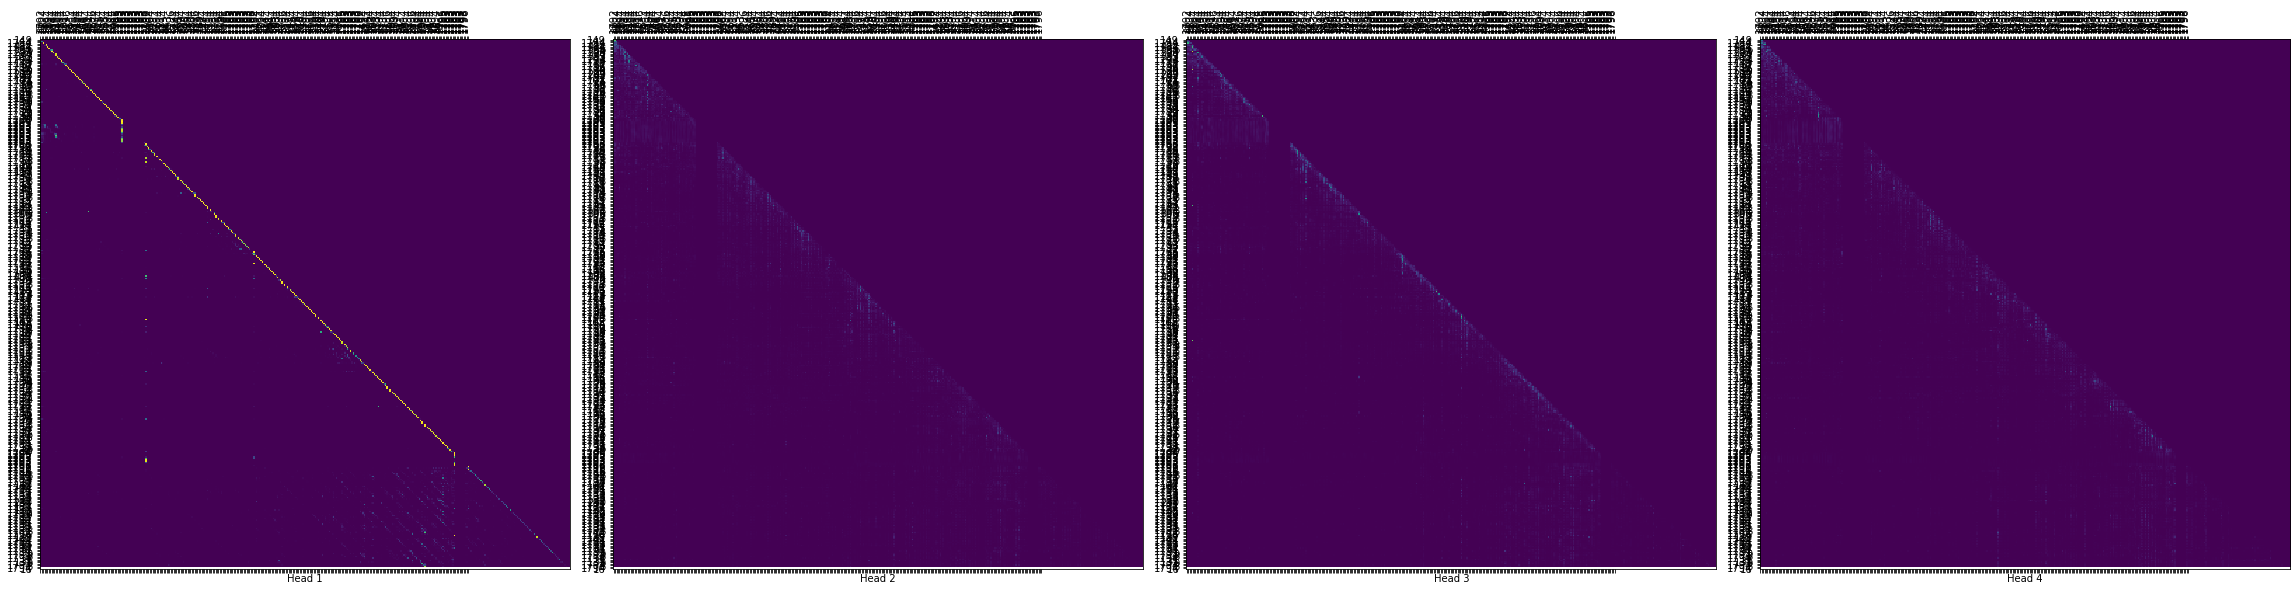

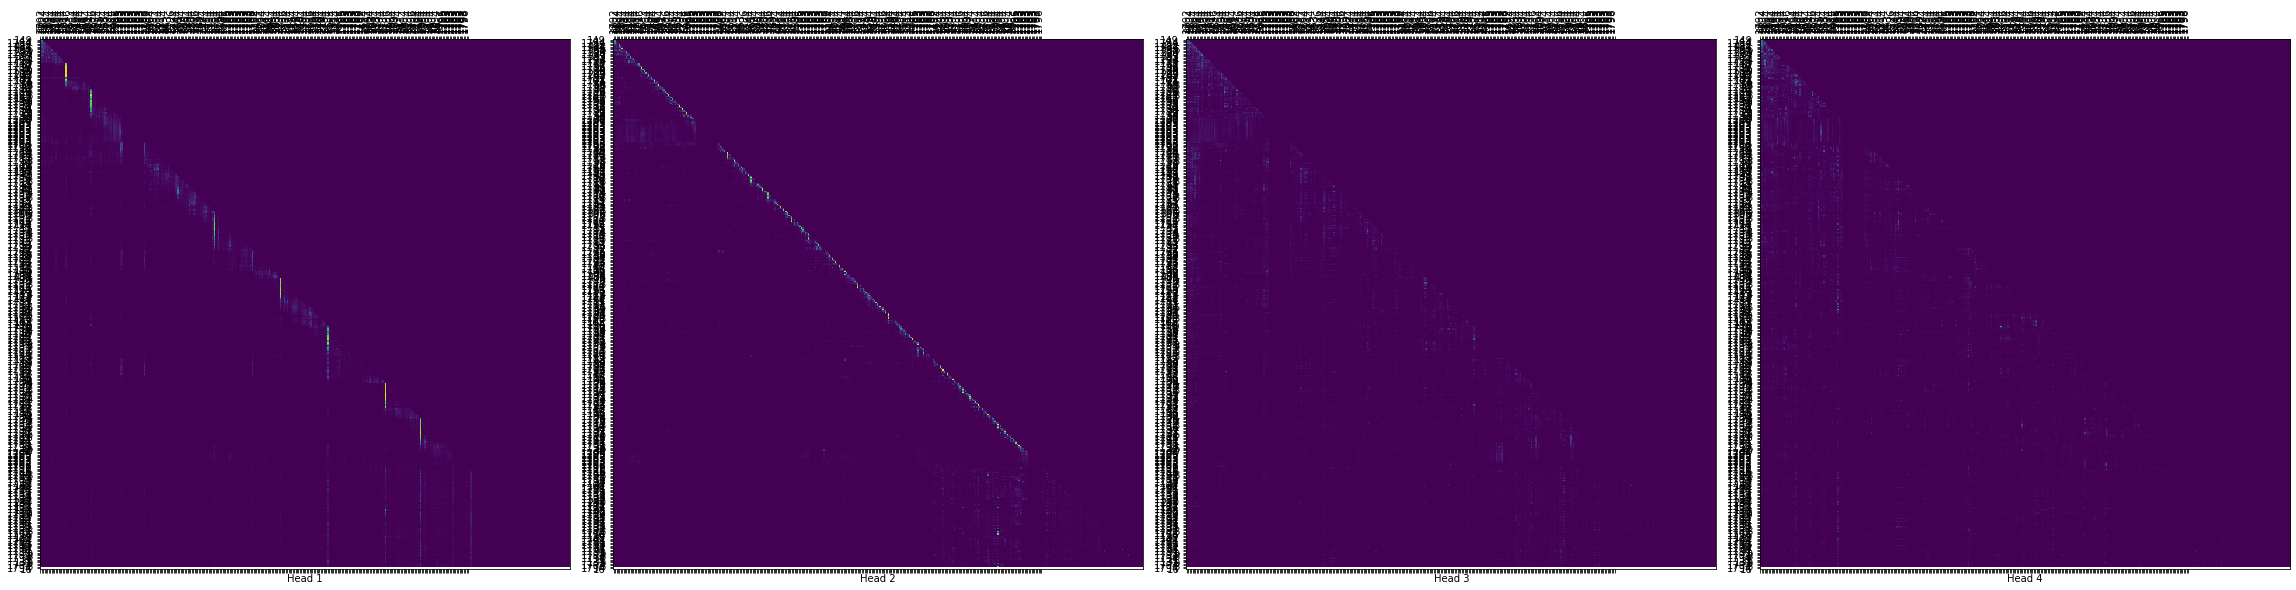

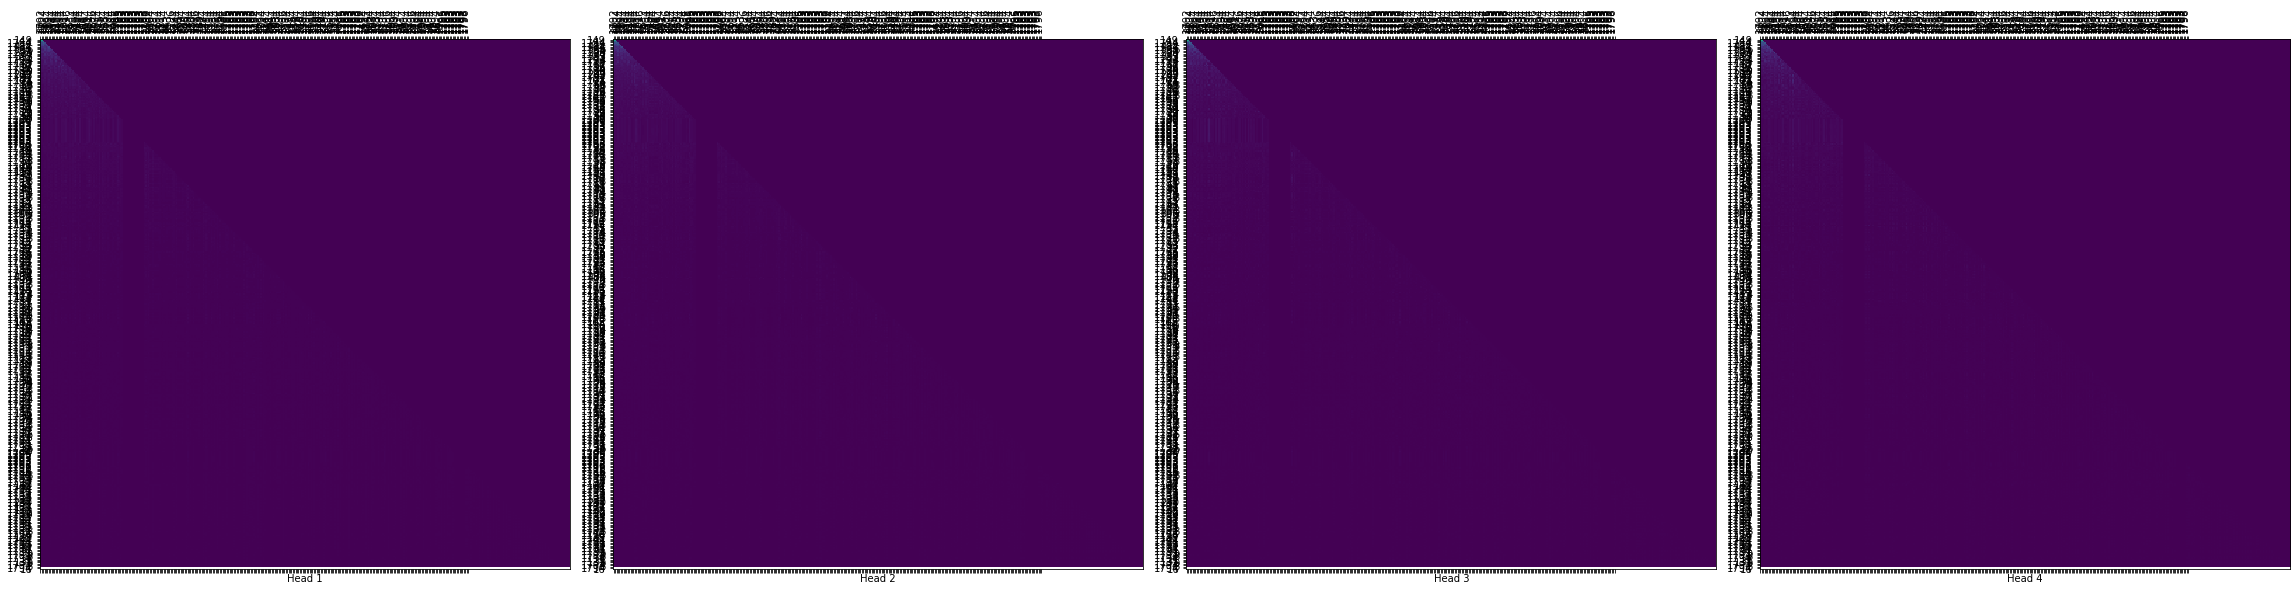

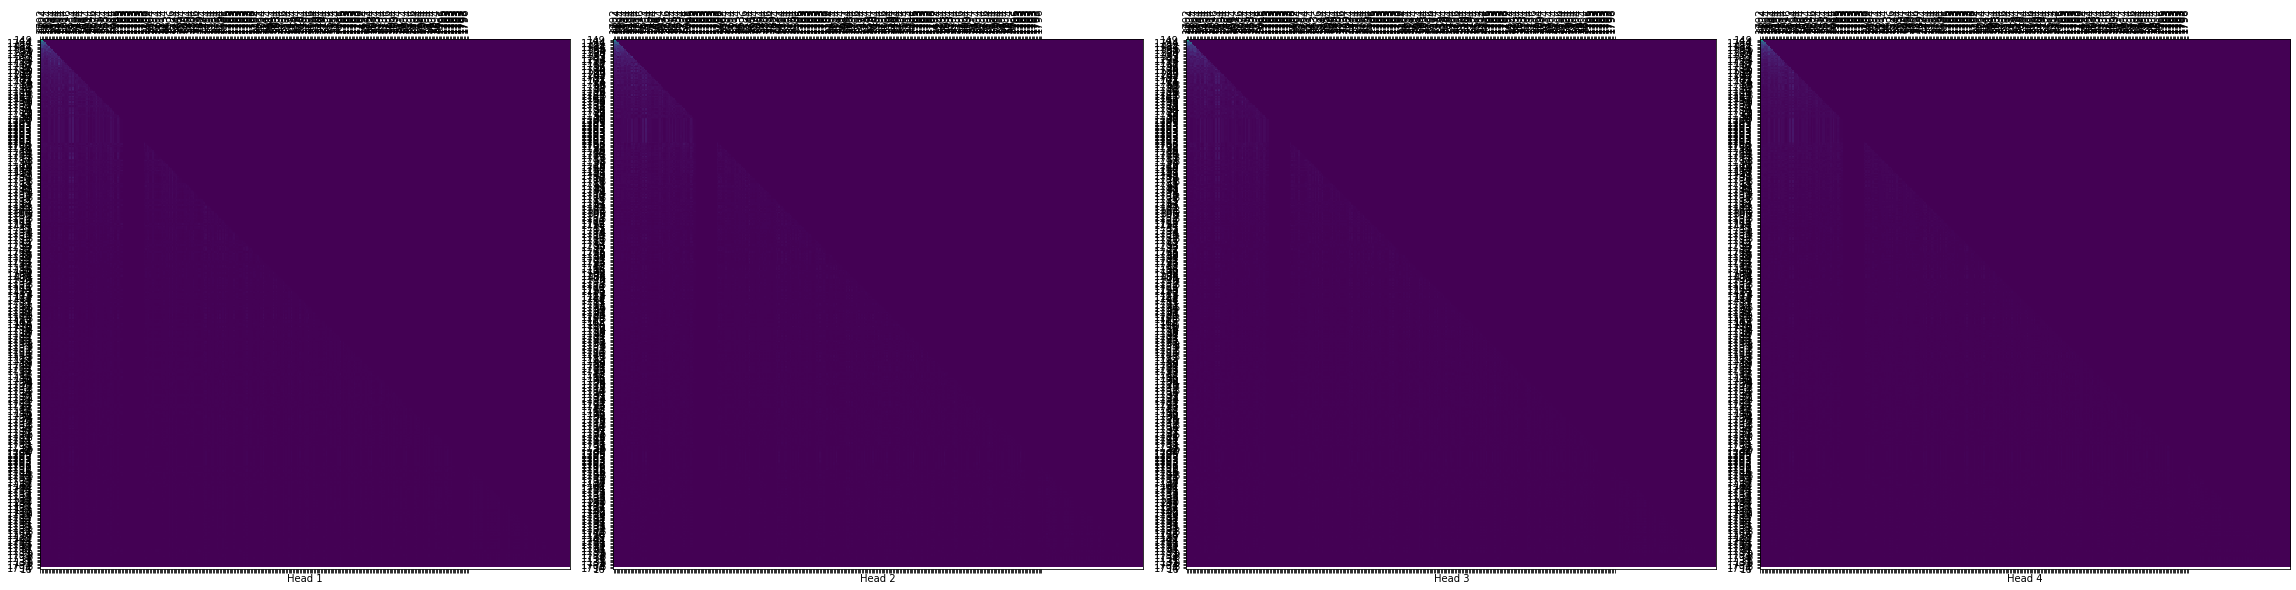

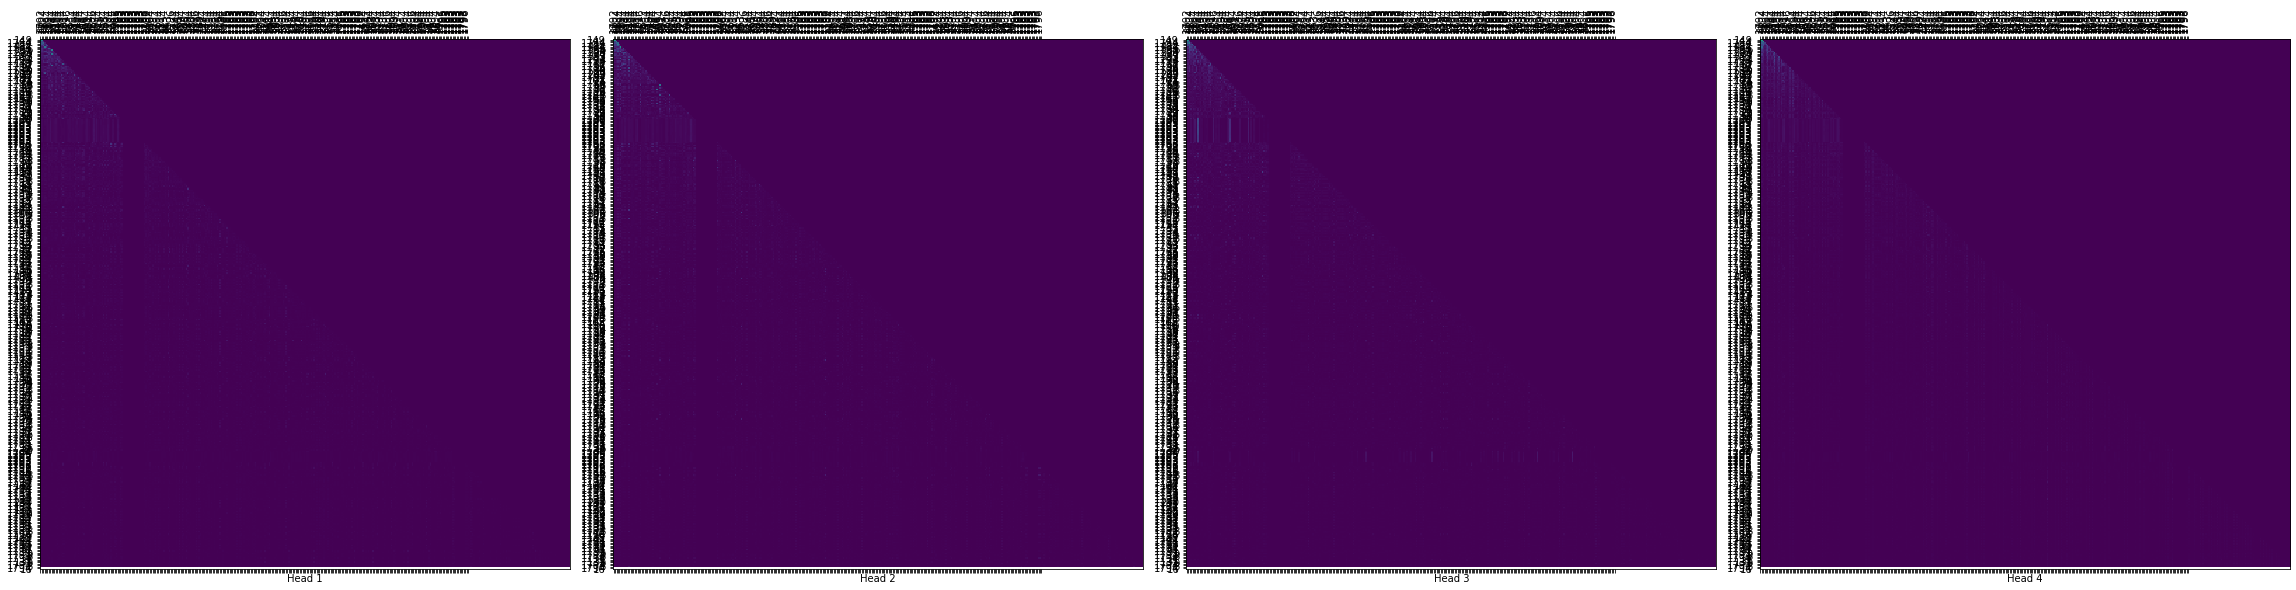

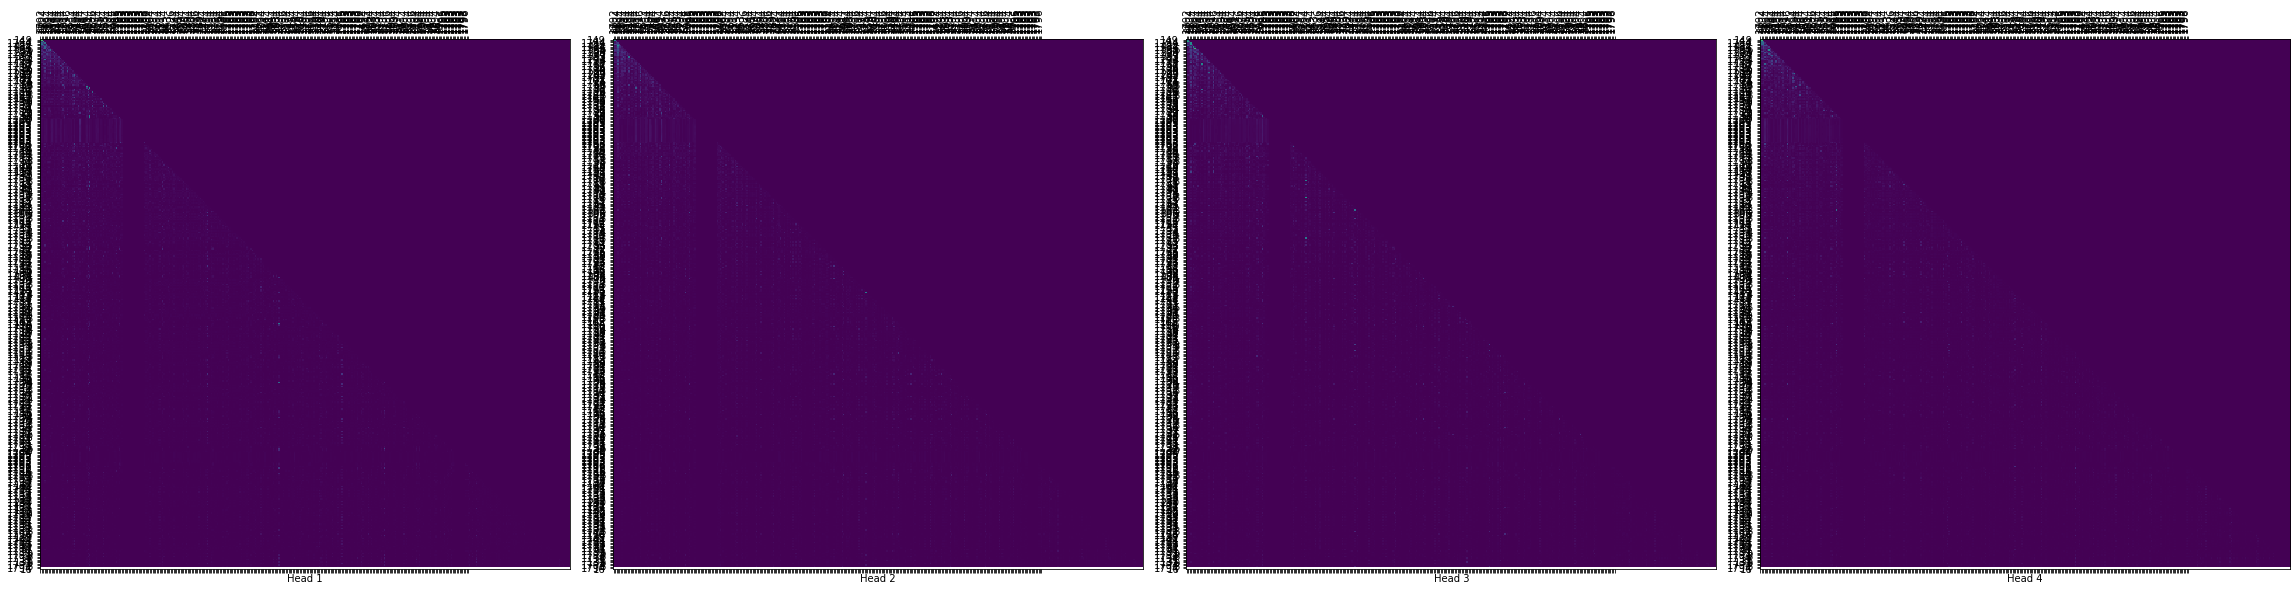

 ma perché l ' una parte del mio corpo l ' altro giro e l ' altro si fe ' suoi
che ' l mio secondo e l ' altro si rimase
 perché non si volse alcuna fa bruno
che ' l mio maestro mio secondo a lui non s ' acqua dura
e perché non si fe ' che ' l ' trista perché non si volse alcuna fare
che ' l viso e non si volse alcuna fame
che ' l viso a me se non si dimora
        

 se
per la fa si ridentro non si si si rità non m prima ti si non non si non la l prima non si non è tanto la seconvento la l 
' è cose il sere e perché la virtú è rada
ché la virtú che perché la virtú è questa
e colui che la virtú dila virtú cura
      
 cosí colui che la cagion che s ' accusta
cominciò l ' anima e l ' altro agala
e come l ' altro è intendi ?
     
 cosí come l ' altro è quel che s ' ingala
che la cagion di quel che la mente
che la mente a quel che non è dimanda


 e io a lui che tu vuo ' che tu m ' ingradi
e ' l maestro che tu vuo ' la pietà m ' avea in quella giona
       
 e io a lui che tu vuo ' che t

In [7]:
#@title Generation

def evaluate(inp_sentence, decoder_input):
    inp_sentence = inp_sentence
    encoder_input = tf.expand_dims(inp_sentence, 0)
    
    output = tf.expand_dims(decoder_input, 0)

    terces = 0
    for i in range(batch_len):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)
    
        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, 
                                                    output,
                                                    False,
                                                    enc_padding_mask,
                                                    combined_mask,
                                                    dec_padding_mask)
        
        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # return the result if the predicted_id is equal to the end token
        if predicted_id == eos:
            terces += 1
            if terces == 3:
                return tf.squeeze(output, axis=0), attention_weights
        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

def plot_attention_weights(attention, sentence, result, layer):
    fig = plt.figure(figsize=(32, 16))
    attention = tf.squeeze(attention[layer], axis=0)
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)
        # plot the attention weights
        ax.matshow(attention[head][:-1, :], cmap='viridis')
        fontdict = {'fontsize': 10}
        ax.set_xticks(range(len(sentence)+2))
        ax.set_yticks(range(len(result)))
        ax.set_ylim(len(result)-1.5, -0.5)
        ax.set_xticklabels(sentence, fontdict=fontdict, rotation=90)
        ax.set_yticklabels(result, fontdict=fontdict)
        ax.set_xlabel('Head {}'.format(head+1))
    plt.tight_layout()
    plt.show()

out_list = test_b[0][0]
print(seq2str(out_list))
txt_gen = seq2str(out_list)+"\n--------------------\n"
offset = 75 # a tercet
print("---------------------------")
for i in range(10): # 30 terces = cantica
    out, att_w = evaluate([pad], out_list[-offset:])
    aa = out.numpy().tolist()
    if i==0: #only once
        plot_attention_weights(att_w, out_list, aa, 'decoder_layer1_block1')
        plot_attention_weights(att_w, out_list, aa, 'decoder_layer2_block1')
        plot_attention_weights(att_w, out_list, aa, 'decoder_layer3_block1')
        plot_attention_weights(att_w, out_list, aa, 'decoder_layer4_block1')
        plot_attention_weights(att_w, out_list, aa, 'decoder_layer5_block1')
        plot_attention_weights(att_w, out_list, aa, 'decoder_layer6_block1')
    out_list = aa
    out_str = seq2str(out_list[offset:])
    txt_gen += out_str + "\n"
    print(out_str) 

wandb.log({"generated": wandb.Html("<pre>"+txt_gen+"</pre>", inject=False)})